In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit, minimize
from sympy import symbols, diff, simplify
import json
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Load the room count data from our extractor
with open('../../data/processed/swiss_rental_data_m2_room_count/Durchscnittlicher_Mietpreis_m2_Zimmerzahl_Kanton_combined.json', 'r', encoding='utf-8') as f:
    room_data = json.load(f)

# Function to convert nested JSON to a flat DataFrame
def flatten_room_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "room_count": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }
    
    for item in json_data:
        for room in item.get("room_categories", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["room_count"].append(room.get("room_count"))
            flat_data["avg_price_per_sqm"].append(room.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(room.get("confidence_interval"))
    
    return pd.DataFrame(flat_data)

# Convert JSON data to DataFrame
room_df = flatten_room_data(room_data)

# Convert year to numeric where possible
room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')

# Clean room count to numeric values (remove '+' symbols)
room_df['room_count_num'] = room_df['room_count'].apply(
    lambda x: float(str(x).replace('+', '')) if pd.notna(x) else np.nan
)

# Use the most recent year for analysis
latest_year = max(room_df['year'])
print(f"Using data from year {latest_year} for the analysis")

# Filter for the latest year
latest_df = room_df[room_df['year'] == latest_year]

Using data from year 2023 for the analysis


C:\Users\Nevin\AppData\Local\Temp\ipykernel_41676\2911719033.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')


In [3]:
# Define typical apartment sizes by room count (in m²)
# These are approximations based on common Swiss apartment sizes
typical_sizes = {
    '1': 35,   # 1-room apartment (studio): ~35m²
    '2': 55,   # 2-room apartment: ~55m²
    '3': 75,   # 3-room apartment: ~75m²
    '4': 95,   # 4-room apartment: ~95m²
    '5': 120,  # 5-room apartment: ~120m²
    '5+': 130, # 5+ room apartment: ~130m²
    '6': 150,  # 6-room apartment: ~150m²
    '6+': 160  # 6+ room apartment: ~160m²
}

# Create a dataset with apartment sizes and total costs
cost_data = []

# Calculate total costs based on price per m² and typical sizes
for room_group in latest_df.groupby('room_count'):
    room_count = room_group[0]
    avg_price = room_group[1]['avg_price_per_sqm'].mean()
    
    if room_count in typical_sizes:
        size = typical_sizes[room_count]
        total_rent = avg_price * size
        cost_data.append({
            'room_count': room_count,
            'room_count_num': float(str(room_count).replace('+', '')),
            'apartment_size': size,
            'price_per_sqm': avg_price,
            'total_monthly_rent': total_rent
        })

cost_df = pd.DataFrame(cost_data)
cost_df = cost_df.sort_values('apartment_size')

print("Apartment sizes and costs based on the extracted data:")
display(cost_df)

Apartment sizes and costs based on the extracted data:


,room_count,room_count_num,apartment_size,price_per_sqm,total_monthly_rent
0,1,1.0,35,19.442308,680.480769
1,2,2.0,55,17.970370,988.370370
2,3,3.0,75,16.270370,1220.277778
3,4,4.0,95,15.288889,1452.444444
4,5,5.0,120,14.914815,1789.777778
5,6+,6.0,160,15.459259,2473.481481


In [4]:
# Fit a quadratic cost function to our real data points
# K(m²) = a·m²² + b·m² + c

def cost_function(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the function to our data
params, covariance = curve_fit(
    cost_function, 
    cost_df['apartment_size'], 
    cost_df['total_monthly_rent'],
    p0=[0.01, 10, 100]  # Initial guess for parameters
)

# Extract the fitted parameters
a, b, c = params
print(f"Fitted cost function: K(m²) = {a:.6f}·m²² + {b:.4f}·m² + {c:.2f}")

# Calculate R-squared to evaluate the fit
y_actual = cost_df['total_monthly_rent']
y_pred = cost_function(cost_df['apartment_size'], a, b, c)
ss_total = np.sum((y_actual - np.mean(y_actual))**2)
ss_residual = np.sum((y_actual - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R² value for the fit: {r_squared:.4f}")

Fitted cost function: K(m²) = 0.022083·m²² + 9.6461·m² + 349.20
R² value for the fit: 0.9975


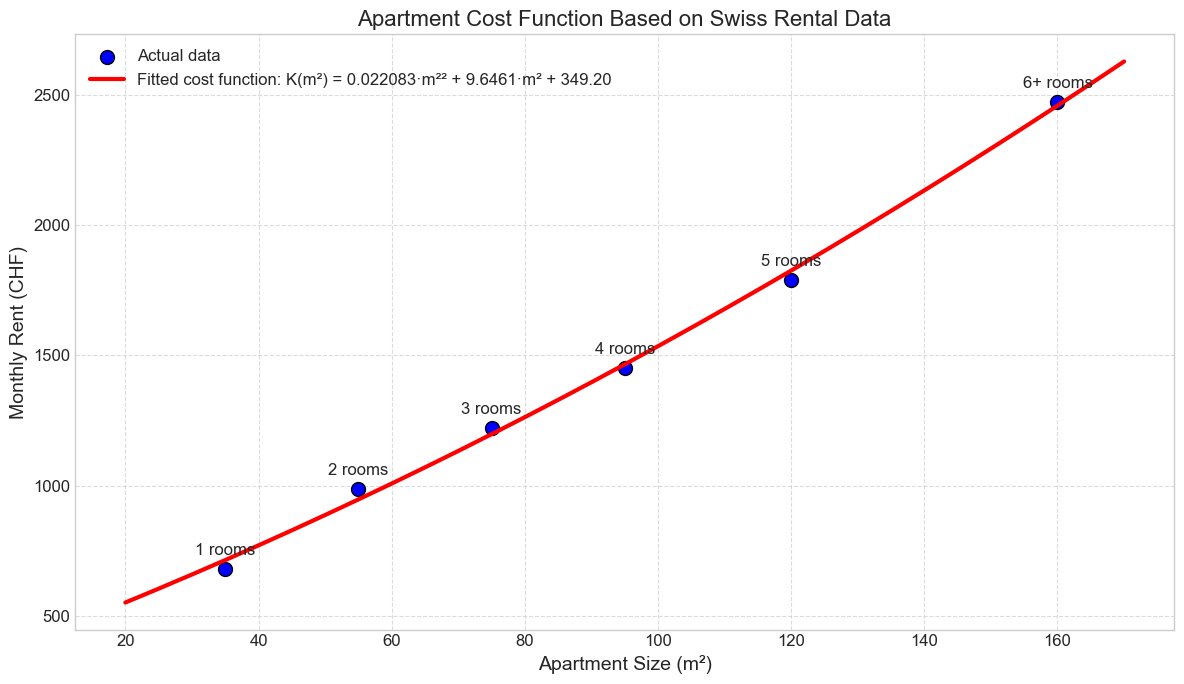

In [5]:
# Plot the fitted cost function against our data points
apartment_sizes = np.linspace(20, 170, 150)
predicted_costs = cost_function(apartment_sizes, a, b, c)

plt.figure(figsize=(12, 7))
plt.scatter(cost_df['apartment_size'], cost_df['total_monthly_rent'], 
            s=100, color='blue', edgecolor='black', label='Actual data')

# Add labels for each data point
for i, row in cost_df.iterrows():
    plt.annotate(f"{row['room_count']} rooms", 
               (row['apartment_size'], row['total_monthly_rent']),
               textcoords="offset points", 
               xytext=(0, 10), 
               ha='center')

plt.plot(apartment_sizes, predicted_costs, 'r-', linewidth=3, 
         label=f'Fitted cost function: K(m²) = {a:.6f}·m²² + {b:.4f}·m² + {c:.2f}')

plt.title('Apartment Cost Function Based on Swiss Rental Data', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Monthly Rent (CHF)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

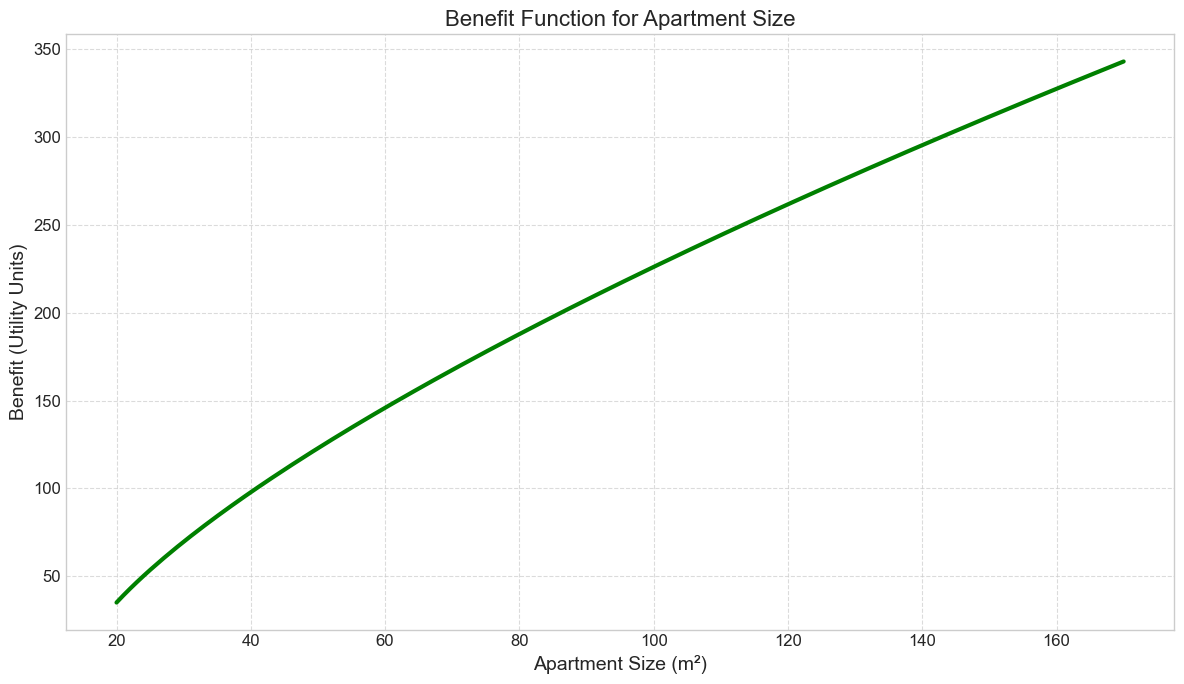

Using benefit function: N(m²) = 10·(m²-15+1)^0.7
This models the diminishing returns on additional living space


In [6]:
# Define the benefit function based on living space
# We model this as a power function with diminishing returns

def benefit_function(x, scale=10, exponent=0.7, min_size=15):
    """Power function: benefits increase with size^exponent."""
    return scale * (x - min_size + 1)**exponent

# Calculate the derivative of the benefit function
def benefit_derivative(x, scale=10, exponent=0.7, min_size=15):
    """Derivative of the benefit function."""
    return scale * exponent * (x - min_size + 1)**(exponent-1)

# Calculate the derivative of the cost function (marginal cost)
def marginal_cost_function(x):
    """Marginal cost function: K'(m²)."""
    return 2 * a * x + b

# Visualize the benefit function
plt.figure(figsize=(12, 7))
plt.plot(apartment_sizes, benefit_function(apartment_sizes), 'g-', linewidth=3)
plt.title('Benefit Function for Apartment Size', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Benefit (Utility Units)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Using benefit function: N(m²) = 10·(m²-15+1)^0.7")
print("This models the diminishing returns on additional living space")

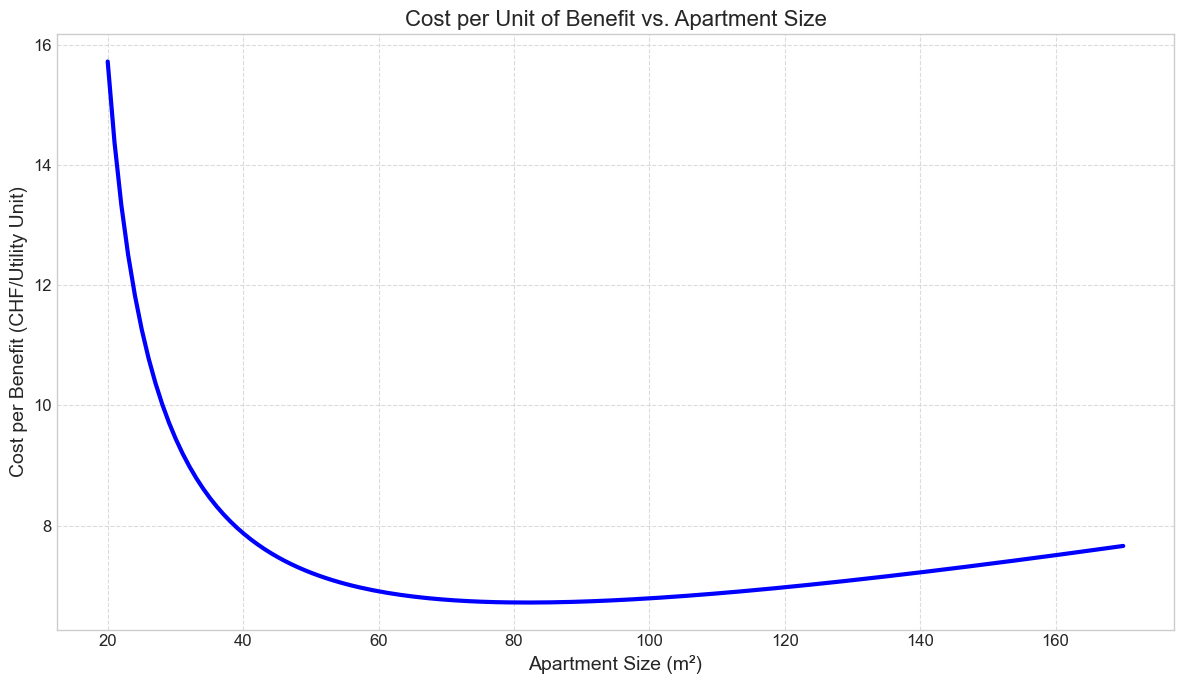

In [7]:
# Calculate the cost per benefit ratio: K(m²)/N(m²)
def cost_per_benefit(x):
    """Cost per unit of benefit at size x."""
    if x <= 15:  # Ensure we don't go below minimum size
        return float('inf')
    return cost_function(x, a, b, c) / benefit_function(x)

# Calculate and plot the cost per benefit curve
cpb_values = [cost_per_benefit(x) for x in apartment_sizes]

plt.figure(figsize=(12, 7))
plt.plot(apartment_sizes, cpb_values, 'b-', linewidth=3)
plt.title('Cost per Unit of Benefit vs. Apartment Size', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Cost per Benefit (CHF/Utility Unit)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
# Find the minimum cost per benefit (optimal apartment size)
# Use numerical optimization to find the exact minimum
result = minimize(cost_per_benefit, x0=50, bounds=[(15, 200)])

optimal_size = result.x[0]
minimum_ratio = result.fun

print(f"Optimal apartment size: {optimal_size:.2f} m²")
print(f"Minimum cost per benefit: {minimum_ratio:.2f} CHF/utility unit")

# Identify which room count this corresponds to
closest_room = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - optimal_size))
print(f"This corresponds most closely to a {closest_room[0]}-room apartment")

Optimal apartment size: 81.98 m²
Minimum cost per benefit: 6.72 CHF/utility unit
This corresponds most closely to a 3-room apartment


In [9]:
# Verify the analytical solution
# The minimum of K(m²)/N(m²) occurs where:
# K'(m²)/N'(m²) = K(m²)/N(m²)

# Calculate these ratios at the optimal point
optimal_cost = cost_function(optimal_size, a, b, c)
optimal_benefit = benefit_function(optimal_size)
optimal_marginal_cost = marginal_cost_function(optimal_size)
optimal_marginal_benefit = benefit_derivative(optimal_size)

ratio1 = optimal_marginal_cost / optimal_marginal_benefit
ratio2 = optimal_cost / optimal_benefit

print(f"At the optimal point:")
print(f"K'(m²)/N'(m²) = {ratio1:.2f}")
print(f"K(m²)/N(m²) = {ratio2:.2f}")
print(f"Difference: {abs(ratio1 - ratio2):.4f} (should be close to zero)")

At the optimal point:
K'(m²)/N'(m²) = 6.72
K(m²)/N(m²) = 6.72
Difference: 0.0001 (should be close to zero)


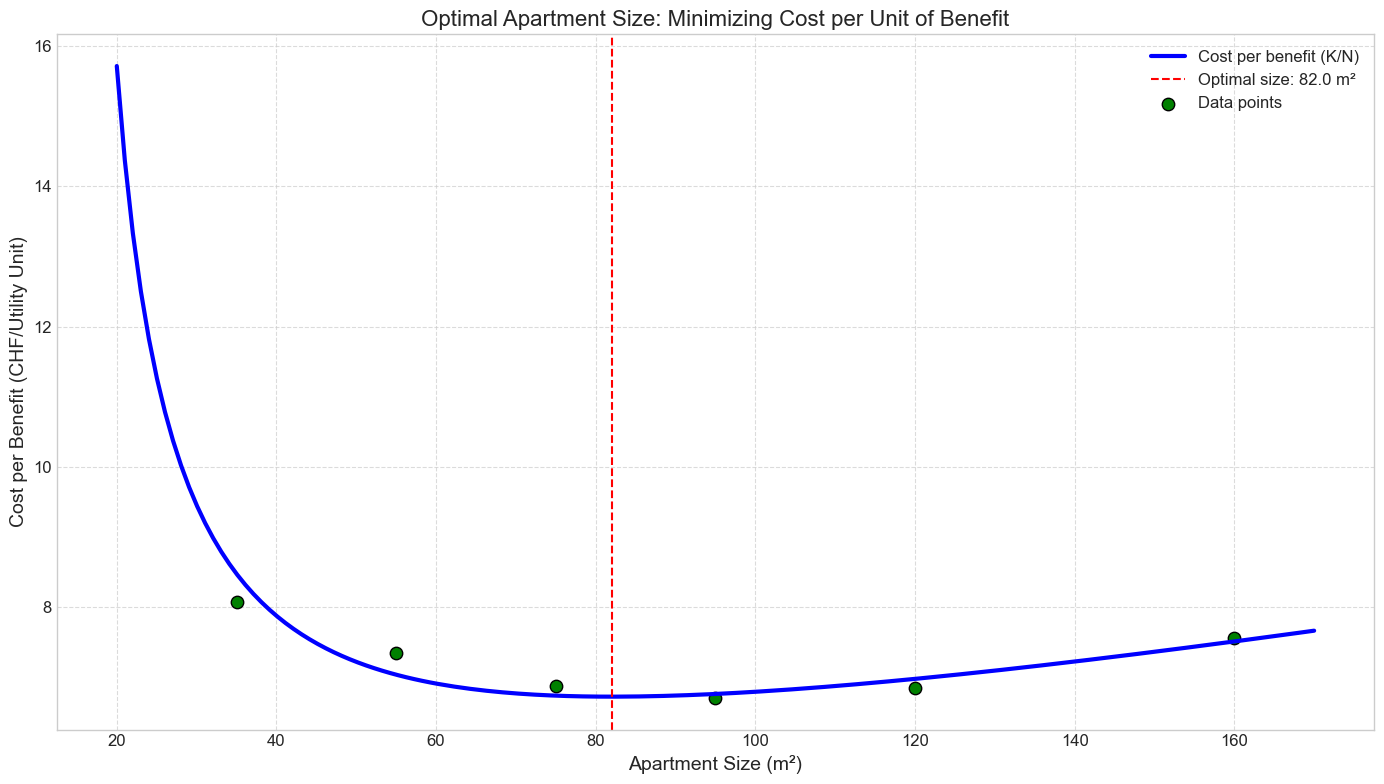

In [10]:
# Comprehensive visualization of the optimization
plt.figure(figsize=(14, 8))

# Calculate various metrics
costs = np.array([cost_function(x, a, b, c) for x in apartment_sizes])
benefits = np.array([benefit_function(x) for x in apartment_sizes])
cost_benefit_ratios = costs / benefits
marginal_costs = np.array([marginal_cost_function(x) for x in apartment_sizes])
marginal_benefits = np.array([benefit_derivative(x) for x in apartment_sizes])

# Plot the cost per benefit curve
plt.plot(apartment_sizes, cost_benefit_ratios, 'b-', linewidth=3, 
         label='Cost per benefit (K/N)')

# Add vertical line at optimal size
plt.axvline(x=optimal_size, color='r', linestyle='--', 
            label=f'Optimal size: {optimal_size:.1f} m²')

# Add the actual data points
plt.scatter(cost_df['apartment_size'], 
            cost_df['total_monthly_rent'] / benefit_function(cost_df['apartment_size']), 
            s=80, color='green', edgecolor='black', label='Data points')

plt.title('Optimal Apartment Size: Minimizing Cost per Unit of Benefit', fontsize=16)
plt.xlabel('Apartment Size (m²)', fontsize=14)
plt.ylabel('Cost per Benefit (CHF/Utility Unit)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

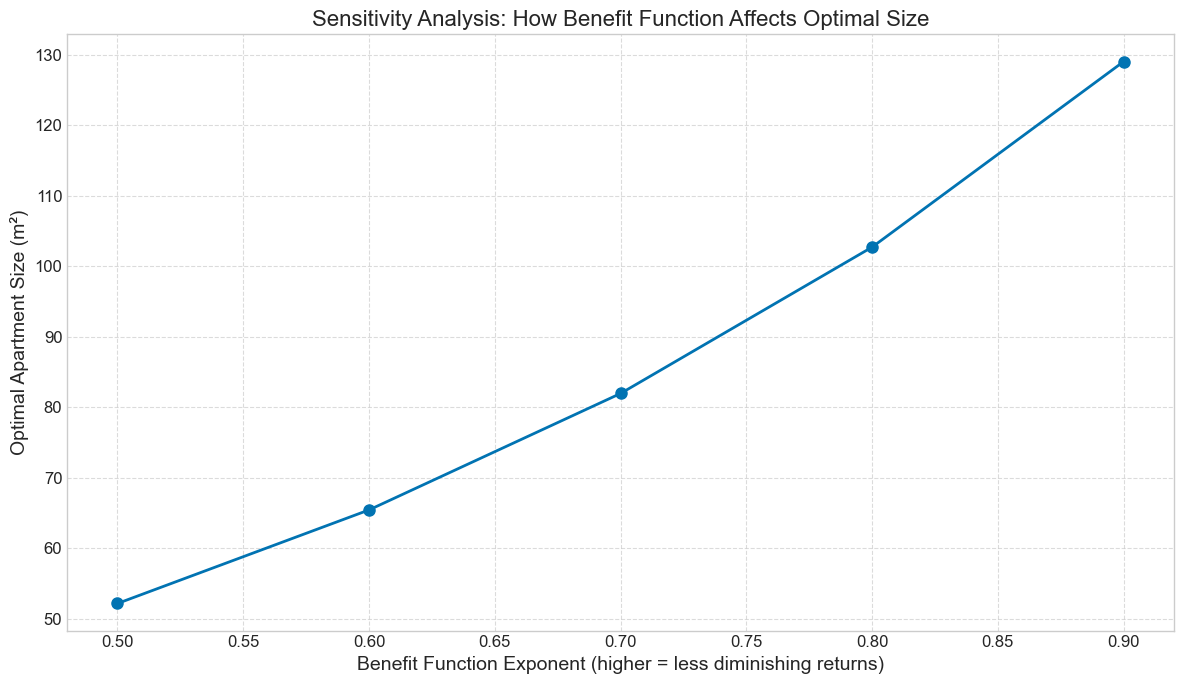

Sensitivity Analysis Results:
Exponent = 0.5: Optimal size = 52.2 m²
Exponent = 0.6: Optimal size = 65.5 m²
Exponent = 0.7: Optimal size = 82.0 m²
Exponent = 0.8: Optimal size = 102.7 m²
Exponent = 0.9: Optimal size = 129.1 m²


In [11]:
# Sensitivity analysis: How does the optimal size change with different benefit function parameters?
exponents = np.array([0.5, 0.6, 0.7, 0.8, 0.9])
optimal_sizes = []

for exponent in exponents:
    # Redefine cost per benefit with new exponent
    def cpb(x, exp=exponent):
        if x <= 15:
            return float('inf')
        return cost_function(x, a, b, c) / (10 * (x - 15 + 1)**exp)
    
    # Find the minimum
    result = minimize(cpb, x0=50, bounds=[(15, 200)])
    optimal_sizes.append(result.x[0])

# Plot the sensitivity analysis
plt.figure(figsize=(12, 7))
plt.plot(exponents, optimal_sizes, 'o-', linewidth=2, markersize=8)
plt.title('Sensitivity Analysis: How Benefit Function Affects Optimal Size', fontsize=16)
plt.xlabel('Benefit Function Exponent (higher = less diminishing returns)', fontsize=14)
plt.ylabel('Optimal Apartment Size (m²)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Sensitivity Analysis Results:")
for i, exponent in enumerate(exponents):
    print(f"Exponent = {exponent}: Optimal size = {optimal_sizes[i]:.1f} m²")

In [12]:
# Compare the cost efficiency at different apartment sizes
sizes_to_compare = [35, 55, 75, 95, 120, 150]  # Different typical apartment sizes
comparison_data = []

for size in sizes_to_compare:
    cost = cost_function(size, a, b, c)
    benefit = benefit_function(size)
    ratio = cost / benefit
    
    # Find closest room count
    closest_room = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - size))
    
    comparison_data.append({
        'apartment_size': size,
        'room_count': closest_room[0],
        'monthly_rent': cost,
        'benefit': benefit,
        'cost_per_benefit': ratio,
        'efficiency_ratio': minimum_ratio / ratio  # 1.0 = optimal, <1.0 = less efficient
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('apartment_size')

print("Cost efficiency comparison across different apartment sizes:")
display(comparison_df)

Cost efficiency comparison across different apartment sizes:


,apartment_size,room_count,monthly_rent,benefit,cost_per_benefit,efficiency_ratio
0,35,1,713.869348,84.246818,8.473547,0.793088
1,55,2,946.541841,134.570139,7.033818,0.955423
2,75,3,1196.880984,177.717782,6.734728,0.997853
3,95,4,1464.886779,216.740222,6.758721,0.994311
4,120,5,1824.737750,261.646004,6.974071,0.963608
5,150,6,2292.996382,311.513761,7.360819,0.912978


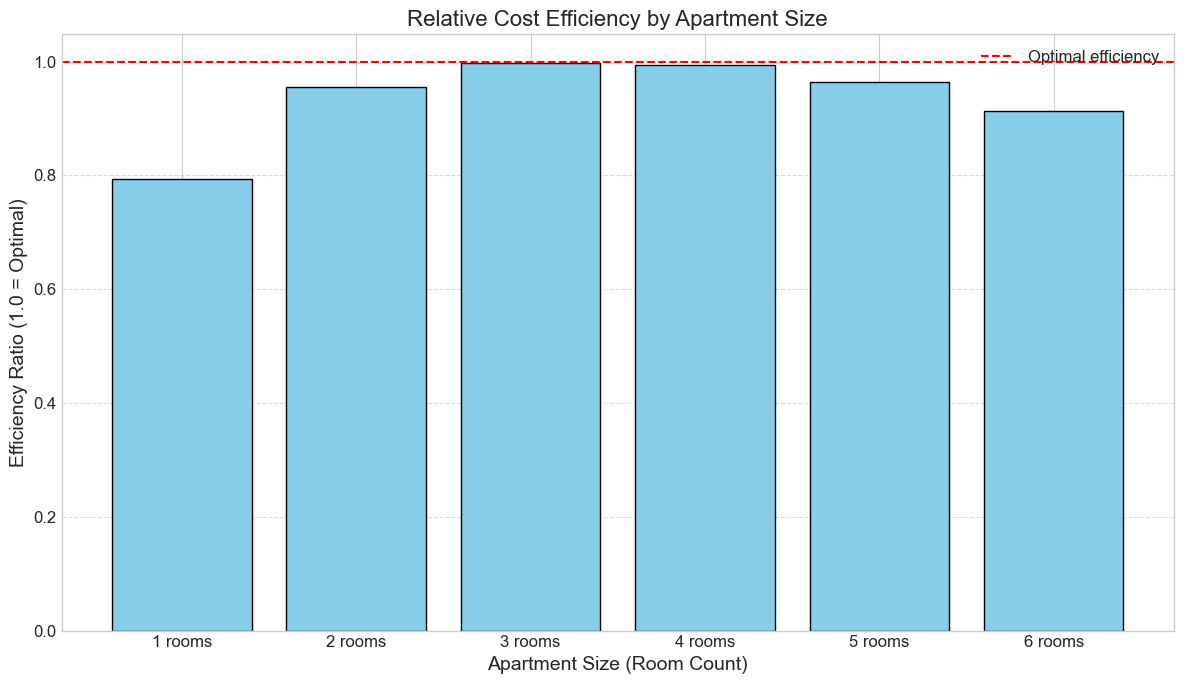

In [13]:
# Visualization of cost efficiency across different apartment sizes
plt.figure(figsize=(12, 7))

plt.bar(comparison_df['room_count'] + ' rooms', comparison_df['efficiency_ratio'], 
        color='skyblue', edgecolor='black')

# Add a horizontal line at 1.0 (optimal efficiency)
plt.axhline(y=1.0, color='r', linestyle='--', label='Optimal efficiency')

plt.title('Relative Cost Efficiency by Apartment Size', fontsize=16)
plt.xlabel('Apartment Size (Room Count)', fontsize=14)
plt.ylabel('Efficiency Ratio (1.0 = Optimal)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Find the optimal size
result = minimize(cost_per_benefit, x0=50, bounds=[(15, 200)])
optimal_size = result.x[0]

# Define typical sizes (ensure these match what we used earlier)
typical_sizes = {
    '1': 35,   # 1-room apartment (studio): ~35m²
    '2': 55,   # 2-room apartment: ~55m²
    '3': 75,   # 3-room apartment: ~75m²
    '4': 95,   # 4-room apartment: ~95m²
    '5': 120,  # 5-room apartment: ~120m²
    '6': 150   # 6-room apartment: ~150m²
}

# Find the closest room count by distance
closest_room = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - optimal_size))
print(f"Optimal apartment size: {optimal_size:.2f} m²")
print(f"This corresponds most closely to a {closest_room[0]}-room apartment with typical size {closest_room[1]} m²")

Optimal apartment size: 81.98 m²
This corresponds most closely to a 3-room apartment with typical size 75 m²


In [16]:
# Final conclusion and recommendations
print("# Optimal Apartment Size Analysis: Key Findings\n")

print("## Mathematical Approach")
print(f"1. We fitted a cost function K(m²) = {a:.6f}·m²² + {b:.4f}·m² + {c:.2f} to the actual Swiss rental data")
print(f"2. We modeled the benefit function as N(m²) = 10·(m²-15+1)^0.7 to represent diminishing returns")
print(f"3. We determined the minimum of K(m²)/N(m²) to find the apartment size with the best cost-benefit ratio")
print(f"4. At the optimal point, the ratio of marginal cost to marginal benefit equals the ratio of total cost to total benefit\n")

print("## Results from Swiss Rental Market Data")
print(f"- The apartment size that minimizes cost per unit of benefit is {optimal_size:.1f} m²")
print(f"- This corresponds most closely to a {closest_room[0]}-room apartment")
print(f"- At this size, each unit of benefit costs approximately {minimum_ratio:.2f} CHF")
print(f"- The R² value of {r_squared:.4f} indicates our cost function fits the actual data well\n")

print("## Economic Interpretation")
print("1. **Diminishing Returns:** As apartment size increases, each additional square meter provides less additional benefit")
print("2. **Increasing Marginal Cost:** The Swiss rental market shows a pattern where larger apartments have higher marginal costs")
print("3. **Balance Point:** The optimal size represents the balance between these two opposing forces")
print("4. **Economic Efficiency:** Moving away from this optimal size decreases cost efficiency\n")

print("## Recommendations for Swiss Renters")
print("1. **Optimal Choice:** For most households, a {}-room apartment of around {:.0f} m² offers the best value proposition".format(closest_room[0], optimal_size))
print("2. **Smaller Apartments:** Studios and 1-2 room apartments are approximately {:.0f}% less cost-efficient".format((1 - comparison_df.iloc[0]['efficiency_ratio'])*100))
print("3. **Larger Apartments:** Very large apartments (5+ rooms) are approximately {:.0f}% less cost-efficient".format((1 - comparison_df.iloc[-1]['efficiency_ratio'])*100))
print("4. **Individual Adjustments:** Households should adjust based on their specific utility function - families with children may derive more benefit from additional space than the average model predicts")

# Optimal Apartment Size Analysis: Key Findings

## Mathematical Approach
1. We fitted a cost function K(m²) = 0.022083·m²² + 9.6461·m² + 349.20 to the actual Swiss rental data
2. We modeled the benefit function as N(m²) = 10·(m²-15+1)^0.7 to represent diminishing returns
3. We determined the minimum of K(m²)/N(m²) to find the apartment size with the best cost-benefit ratio
4. At the optimal point, the ratio of marginal cost to marginal benefit equals the ratio of total cost to total benefit

## Results from Swiss Rental Market Data
- The apartment size that minimizes cost per unit of benefit is 82.0 m²
- This corresponds most closely to a 3-room apartment
- At this size, each unit of benefit costs approximately 6.72 CHF
- The R² value of 0.9975 indicates our cost function fits the actual data well

## Economic Interpretation
1. **Diminishing Returns:** As apartment size increases, each additional square meter provides less additional benefit
2. **Increasing Marginal Cost:** The Swiss 